# Import Packages

In [1]:
"""
Setup and Imports
"""
import sys
from pathlib import Path
from datetime import datetime, timedelta, timezone
from typing import Tuple, Optional
import warnings
warnings.filterwarnings('ignore')

# Add project root to path
project_root = Path().resolve().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

# Load environment variables from .env file
from dotenv import load_dotenv
env_path = project_root / ".env"
if env_path.exists():
    load_dotenv(env_path)
    print(f"Loaded environment variables from: {env_path}")
else:
    print(f"Warning: .env file not found at {env_path}")
    print("Please ensure your database credentials are set in environment variables or .env file")

# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# optuna
import optuna

# Database
from sqlalchemy import select, desc
from src.shared.database.base import db_readonly_session
from src.shared.database.models.market_data import MarketData
from src.shared.database.models.technical_indicators import TechnicalIndicators

# statsmodel
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox

Loaded environment variables from: D:\PythonProjects\Trading-System\.env


In [2]:
# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)

# Set random seeds for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(RANDOM_SEED)
    torch.backends.cudnn.deterministic = True

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.7.0+cu128
CUDA available: True
CUDA device: NVIDIA GeForce RTX 3050 Laptop GPU


# Data Loading

In [3]:
def load_market_data_with_indicators(
    symbol: str,
    start_date: Optional[datetime] = None,
    end_date: Optional[datetime] = None,
    data_source: str = "yahoo",
    min_records: int = 1000
) -> pd.DataFrame:
    """
    Load market data and technical indicators from database for a specific symbol.
    
    This function loads OHLCV data from market_data table and joins it with
    pre-calculated technical indicators from analytics.technical_indicators table.
    
    Args:
        symbol: Stock symbol (e.g., 'AAPL')
        start_date: Start date (default: 1 year ago)
        end_date: End date (default: today)
        data_source: Data source filter ('yahoo', 'polygon', 'alpaca')
        min_records: Minimum number of records required
        
    Returns:
        DataFrame with OHLCV data and technical indicators indexed by timestamp
    """
    if start_date is None:
        start_date = datetime.now(timezone.utc) - timedelta(days=365)
    if end_date is None:
        end_date = datetime.now(timezone.utc)
    
    symbol_upper = symbol.upper()
    
    # Load market data
    with db_readonly_session() as session:
        # Query market data
        market_query = (
            select(MarketData)
            .where(MarketData.symbol == symbol_upper)
            .where(MarketData.data_source == data_source.lower())
            .where(MarketData.timestamp >= start_date)
            .where(MarketData.timestamp <= end_date)
            .order_by(MarketData.timestamp)
        )
        
        market_result = session.execute(market_query)
        market_records = market_result.scalars().all()
    
    if len(market_records) < min_records:
        raise ValueError(
            f"Insufficient data: {len(market_records)} records found, "
            f"minimum {min_records} required"
        )
    
    # Convert market data to DataFrame
    market_data = []
    for record in market_records:
        if record.is_complete:  # Only include complete OHLCV records
            # Convert timestamp to date for joining with technical indicators
            market_data.append({
                'date': record.timestamp.date(),
                'timestamp': record.timestamp,
                'open': float(record.open),
                'high': float(record.high),
                'low': float(record.low),
                'close': float(record.close),
                'volume': int(record.volume) if record.volume else 0,
            })
    
    df_market = pd.DataFrame(market_data)
    
    # Load technical indicators
    with db_readonly_session() as session:
        # Query technical indicators
        ti_query = (
            select(TechnicalIndicators)
            .where(TechnicalIndicators.symbol == symbol_upper)
            .where(TechnicalIndicators.date >= start_date.date())
            .where(TechnicalIndicators.date <= end_date.date())
            .order_by(TechnicalIndicators.date)
        )
        
        ti_result = session.execute(ti_query)
        ti_records = ti_result.scalars().all()
    
    # Convert technical indicators to DataFrame
    ti_data = []
    for record in ti_records:
        ti_data.append({
            'date': record.date,
            # Moving Averages
            'sma_20': float(record.sma_20) if record.sma_20 else None,
            'sma_50': float(record.sma_50) if record.sma_50 else None,
            'sma_200': float(record.sma_200) if record.sma_200 else None,
            'ema_12': float(record.ema_12) if record.ema_12 else None,
            'ema_26': float(record.ema_26) if record.ema_26 else None,
            'ema_50': float(record.ema_50) if record.ema_50 else None,
            # Momentum
            'rsi': float(record.rsi) if record.rsi else None,
            'rsi_14': float(record.rsi_14) if record.rsi_14 else None,
            # MACD
            'macd_line': float(record.macd_line) if record.macd_line else None,
            'macd_signal': float(record.macd_signal) if record.macd_signal else None,
            'macd_histogram': float(record.macd_histogram) if record.macd_histogram else None,
            # Bollinger Bands
            'bb_upper': float(record.bb_upper) if record.bb_upper else None,
            'bb_middle': float(record.bb_middle) if record.bb_middle else None,
            'bb_lower': float(record.bb_lower) if record.bb_lower else None,
            'bb_position': float(record.bb_position) if record.bb_position else None,
            'bb_width': float(record.bb_width) if record.bb_width else None,
            # Volatility & Price Changes
            'volatility_20': float(record.volatility_20) if record.volatility_20 else None,
            'price_change_1d': float(record.price_change_1d) if record.price_change_1d else None,
            'price_change_5d': float(record.price_change_5d) if record.price_change_5d else None,
            'price_change_30d': float(record.price_change_30d) if record.price_change_30d else None,
            # Volume
            'avg_volume_20': int(record.avg_volume_20) if record.avg_volume_20 else None,
            'current_volume': int(record.current_volume) if record.current_volume else None,
        })
    
    df_ti = pd.DataFrame(ti_data)
    
    # Merge market data with technical indicators on date
    if not df_ti.empty:
        df = df_market.merge(df_ti, on='date', how='left')
        print(f"Loaded {len(df_market)} market data records")
        print(f"Loaded {len(df_ti)} technical indicator records")
        print(f"Merged dataset: {len(df)} records")
    else:
        print(f"Warning: No technical indicators found for {symbol}")
        print("Using market data only. Consider running populate_technical_indicators.py")
        df = df_market.copy()
    
    # Set timestamp as index (use market data timestamp)
    df.set_index('timestamp', inplace=True)
    df.sort_index(inplace=True)
    
    # Remove duplicates (keep last)
    df = df[~df.index.duplicated(keep='last')]
    
    # Calculate basic returns if not available from indicators
    if 'returns' not in df.columns:
        df['returns'] = df['close'].pct_change()
    if 'log_returns' not in df.columns:
        df['log_returns'] = np.log(df['close'] / df['close'].shift(1))
    
    # Price ratios
    df['high_low_ratio'] = df['high'] / df['low']
    df['close_open_ratio'] = df['close'] / df['open']
    
    # Volume ratio (if we have avg_volume_20)
    if 'avg_volume_20' in df.columns and df['avg_volume_20'].notna().any():
        df['volume_ratio'] = df['volume'] / df['avg_volume_20']
    else:
        df['volume_ratio'] = None
    
    # Price position (where close is relative to high-low range)
    df['price_position'] = (df['close'] - df['low']) / (df['high'] - df['low'])
    
    print(f"\nFinal dataset: {len(df)} records")
    print(f"Date range: {df.index.min()} to {df.index.max()}")
    print(f"Missing values: {df.isnull().sum().sum()}")
    print(f"\nAvailable features: {list(df.columns)}")
    
    return df

In [4]:
# Load data for a symbol (change as needed)
SYMBOL = "MU"
df_features = load_market_data_with_indicators(SYMBOL, data_source="yahoo")
df_features.head()

2025-12-21 08:13:06.144 | DEBUG    | src.shared.database.base:db_readonly_session:156 - Read-only session completed successfully
2025-12-21 08:13:06.176 | DEBUG    | src.shared.database.base:db_readonly_session:156 - Read-only session completed successfully


Loaded 1731 market data records
Loaded 365 technical indicator records
Merged dataset: 1731 records

Final dataset: 1731 records
Date range: 2024-12-23 03:30:00-06:00 to 2025-12-19 09:30:00-06:00
Missing values: 2

Available features: ['date', 'open', 'high', 'low', 'close', 'volume', 'sma_20', 'sma_50', 'sma_200', 'ema_12', 'ema_26', 'ema_50', 'rsi', 'rsi_14', 'macd_line', 'macd_signal', 'macd_histogram', 'bb_upper', 'bb_middle', 'bb_lower', 'bb_position', 'bb_width', 'volatility_20', 'price_change_1d', 'price_change_5d', 'price_change_30d', 'avg_volume_20', 'current_volume', 'returns', 'log_returns', 'high_low_ratio', 'close_open_ratio', 'volume_ratio', 'price_position']


,date,open,high,low,close,volume,sma_20,sma_50,sma_200,ema_12,...,price_change_5d,price_change_30d,avg_volume_20,current_volume,returns,log_returns,high_low_ratio,close_open_ratio,volume_ratio,price_position
timestamp,,,,,,,,,,,,,,,,,,,,,
2024-12-23 03:30:00-06:00,2024-12-23,90.145,91.1000,88.400,88.500,6648844,99.8347,102.9651,110.7619,97.6045,...,-16.97,-19.71,23231731,21724019,NaN,NaN,1.030543,0.981752,0.286197,0.037037
2024-12-23 04:30:00-06:00,2024-12-23,88.520,89.2000,88.400,89.060,2661600,99.8347,102.9651,110.7619,97.6045,...,-16.97,-19.71,23231731,21724019,0.006328,0.006308,1.009050,1.006100,0.114567,0.825000
2024-12-23 05:30:00-06:00,2024-12-23,89.057,89.4100,88.432,88.585,2726427,99.8347,102.9651,110.7619,97.6045,...,-16.97,-19.71,23231731,21724019,-0.005333,-0.005348,1.011059,0.994700,0.117358,0.156442
2024-12-23 06:30:00-06:00,2024-12-23,88.585,89.4213,88.585,89.160,2008035,99.8347,102.9651,110.7619,97.6045,...,-16.97,-19.71,23231731,21724019,0.006491,0.006470,1.009441,1.006491,0.086435,0.687552
2024-12-23 07:30:00-06:00,2024-12-23,89.140,90.0050,89.030,89.790,1920008,99.8347,102.9651,110.7619,97.6045,...,-16.97,-19.71,23231731,21724019,0.007066,0.007041,1.010951,1.007292,0.082646,0.779487


# Data Overview

In [5]:
# Display data summary
print(f"Dataset shape: {df_features.shape}")
print(f"\nColumn types:")
print(df_features.dtypes)

Dataset shape: (1731, 34)

Column types:
date                 object
open                float64
high                float64
low                 float64
close               float64
volume                int64
sma_20              float64
sma_50              float64
sma_200             float64
ema_12              float64
ema_26              float64
ema_50              float64
rsi                 float64
rsi_14              float64
macd_line           float64
macd_signal         float64
macd_histogram      float64
bb_upper            float64
bb_middle           float64
bb_lower            float64
bb_position         float64
bb_width            float64
volatility_20       float64
price_change_1d     float64
price_change_5d     float64
price_change_30d    float64
avg_volume_20         int64
current_volume        int64
returns             float64
log_returns         float64
high_low_ratio      float64
close_open_ratio    float64
volume_ratio        float64
price_position      float64
dtype: 

In [6]:
print(f"\nMissing values per column:")
missing = df_features.isnull().sum()
print(missing[missing > 0])


Missing values per column:
returns        1
log_returns    1
dtype: int64


In [7]:
# Remove rows with null values
rows_before = len(df_features)
print(f"\nRows before removing nulls: {rows_before}")
df_features = df_features.dropna()
rows_after = len(df_features)
print(f"Rows after removing nulls: {rows_after}")
print(f"Removed {rows_before - rows_after} rows with null values")


Rows before removing nulls: 1731
Rows after removing nulls: 1730
Removed 1 rows with null values


In [8]:
print(f"\nFirst few rows:")
df_features.head(2)


First few rows:


,date,open,high,low,close,volume,sma_20,sma_50,sma_200,ema_12,...,price_change_5d,price_change_30d,avg_volume_20,current_volume,returns,log_returns,high_low_ratio,close_open_ratio,volume_ratio,price_position
timestamp,,,,,,,,,,,,,,,,,,,,,
2024-12-23 04:30:00-06:00,2024-12-23,88.520,89.20,88.400,89.060,2661600,99.8347,102.9651,110.7619,97.6045,...,-16.97,-19.71,23231731,21724019,0.006328,0.006308,1.009050,1.0061,0.114567,0.825000
2024-12-23 05:30:00-06:00,2024-12-23,89.057,89.41,88.432,88.585,2726427,99.8347,102.9651,110.7619,97.6045,...,-16.97,-19.71,23231731,21724019,-0.005333,-0.005348,1.011059,0.9947,0.117358,0.156442


# Target Transformation


In [9]:
# Target Transformation: Convert raw prices into Log Returns or Percentage Returns
# This is useful for time series prediction tasks where we predict returns instead of absolute prices

# Store original close price for inverse transformation later
df_features['close_original'] = df_features['close'].copy()

# Option 1: Percentage Returns - rename existing 'returns' column
# Percentage return: (P_t - P_{t-1}) / P_{t-1}
df_features.rename(columns={'returns': 'target_pct_return'}, inplace=True)

# Option 2: Log Returns - rename existing 'log_returns' column
# Log return: ln(P_t / P_{t-1}) = ln(P_t) - ln(P_{t-1})
df_features.rename(columns={'log_returns': 'target_log_return'}, inplace=True)

## Target overview

In [10]:
# Display target variable statistics
print("Target Variable Statistics:")
print("=" * 60)
print("\n1. Percentage Returns (target_pct_return):")
print(df_features['target_pct_return'].describe())
print(f"\n   Missing values: {df_features['target_pct_return'].isnull().sum()}")

print("\n2. Log Returns (target_log_return):")
print(df_features['target_log_return'].describe())
print(f"\n   Missing values: {df_features['target_log_return'].isnull().sum()}")

Target Variable Statistics:

1. Percentage Returns (target_pct_return):
count    1730.000000
mean        0.000742
std         0.014602
min        -0.118644
25%        -0.004311
50%         0.000309
75%         0.005143
max         0.111334
Name: target_pct_return, dtype: float64

   Missing values: 0

2. Log Returns (target_log_return):
count    1730.000000
mean        0.000636
std         0.014566
min        -0.126294
25%        -0.004320
50%         0.000309
75%         0.005130
max         0.105561
Name: target_log_return, dtype: float64

   Missing values: 0


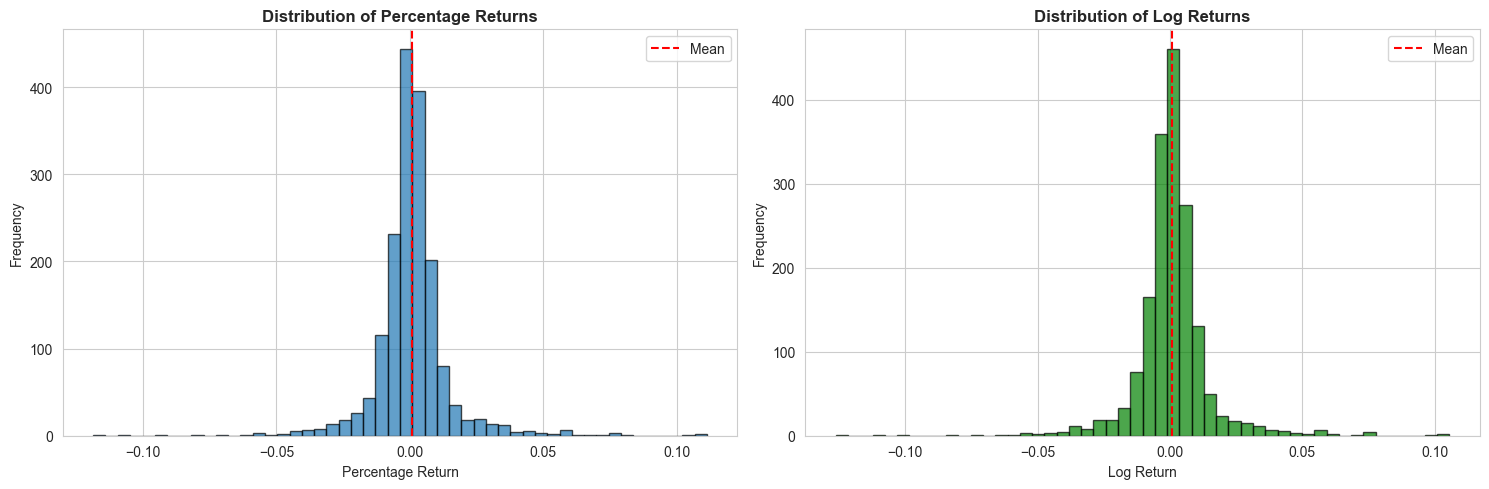

In [11]:
# Visualize target distributions
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Percentage Returns
axes[0].hist(df_features['target_pct_return'].dropna(), bins=50, edgecolor='black', alpha=0.7)
axes[0].set_title('Distribution of Percentage Returns', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Percentage Return')
axes[0].set_ylabel('Frequency')
axes[0].axvline(df_features['target_pct_return'].mean(), color='red', linestyle='--', label='Mean')
axes[0].legend()

# Log Returns
axes[1].hist(df_features['target_log_return'].dropna(), bins=50, edgecolor='black', alpha=0.7, color='green')
axes[1].set_title('Distribution of Log Returns', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Log Return')
axes[1].set_ylabel('Frequency')
axes[1].axvline(df_features['target_log_return'].mean(), color='red', linestyle='--', label='Mean')
axes[1].legend()

plt.tight_layout()
plt.show()

In [12]:
print("\n" + "=" * 60)
print("Note: Choose your target variable based on your prediction task:")
print("  - target_pct_return: Current period percentage return")
print("  - target_log_return: Current period log return")

print("=" * 60)


Note: Choose your target variable based on your prediction task:
  - target_pct_return: Current period percentage return
  - target_log_return: Current period log return


In [13]:
df_features.columns

Index(['date', 'open', 'high', 'low', 'close', 'volume', 'sma_20', 'sma_50',
       'sma_200', 'ema_12', 'ema_26', 'ema_50', 'rsi', 'rsi_14', 'macd_line',
       'macd_signal', 'macd_histogram', 'bb_upper', 'bb_middle', 'bb_lower',
       'bb_position', 'bb_width', 'volatility_20', 'price_change_1d',
       'price_change_5d', 'price_change_30d', 'avg_volume_20',
       'current_volume', 'target_pct_return', 'target_log_return',
       'high_low_ratio', 'close_open_ratio', 'volume_ratio', 'price_position',
       'close_original'],
      dtype='object')

## Stationarity Test: Augmented Dickey-Fuller (ADF) Test


In [14]:
# Augmented Dickey-Fuller (ADF) Test for Stationarity
# This test checks if the time series has a unit root (non-stationary)
# We want to reject the null hypothesis (p-value < 0.05) to confirm stationarity

# Prepare the data: drop NaN values from target_log_return
target_series = df_features['target_log_return'].dropna()

# Perform ADF test
adf_result = adfuller(target_series, autolag='AIC')

In [15]:
# Extract results
adf_statistic = adf_result[0]
p_value = adf_result[1]
critical_values = adf_result[4]
n_lags = adf_result[2]
n_obs = adf_result[3]

In [16]:
# Display results
print("=" * 70)
print("Augmented Dickey-Fuller (ADF) Test Results")
print("=" * 70)
print(f"\nTest Statistic: {adf_statistic:.6f}")
print(f"p-value: {p_value:.6f}")
print(f"Number of Lags Used: {n_lags}")
print(f"Number of Observations: {n_obs}")
print(f"\nCritical Values:")
for key, value in critical_values.items():
    print(f"  {key}: {value:.6f}")

print("\n" + "=" * 70)

Augmented Dickey-Fuller (ADF) Test Results

Test Statistic: -14.682042
p-value: 0.000000
Number of Lags Used: 6
Number of Observations: 1723

Critical Values:
  1%: -3.434151
  5%: -2.863219
  10%: -2.567664



In [17]:
print("Interpretation:")
print("=" * 70)

if p_value < 0.05:
    print(f"✓ p-value ({p_value:.6f}) < 0.05")
    print("✓ NULL HYPOTHESIS REJECTED")
    print("✓ The series is STATIONARY")
    print("✓ Safe for LSTM to learn patterns from")
    is_stationary = True
else:
    print(f"✗ p-value ({p_value:.6f}) >= 0.05")
    print("✗ NULL HYPOTHESIS NOT REJECTED")
    print("✗ The series may be NON-STATIONARY")
    print("✗ Consider differencing or other transformations")
    is_stationary = False

print("=" * 70)

Interpretation:
✓ p-value (0.000000) < 0.05
✓ NULL HYPOTHESIS REJECTED
✓ The series is STATIONARY
✓ Safe for LSTM to learn patterns from


In [18]:
# Additional check: Compare test statistic with critical values
print(f"\nTest Statistic vs Critical Values:")
if adf_statistic < critical_values['1%']:
    print(f"  Test statistic ({adf_statistic:.6f}) < 1% critical value ({critical_values['1%']:.6f})")
    print("  → Strong evidence against null hypothesis (99% confidence)")
elif adf_statistic < critical_values['5%']:
    print(f"  Test statistic ({adf_statistic:.6f}) < 5% critical value ({critical_values['5%']:.6f})")
    print("  → Evidence against null hypothesis (95% confidence)")
elif adf_statistic < critical_values['10%']:
    print(f"  Test statistic ({adf_statistic:.6f}) < 10% critical value ({critical_values['10%']:.6f})")
    print("  → Weak evidence against null hypothesis (90% confidence)")
else:
    print(f"  Test statistic ({adf_statistic:.6f}) >= 10% critical value ({critical_values['10%']:.6f})")
    print("  → No evidence against null hypothesis (series is likely non-stationary)")

print("=" * 70)


Test Statistic vs Critical Values:
  Test statistic (-14.682042) < 1% critical value (-3.434151)
  → Strong evidence against null hypothesis (99% confidence)


## Volatility Clustering (Heteroskedasticity) Check

In [19]:
# Check for Volatility Clustering (Heteroskedasticity)
# Volatility clustering: periods of high volatility followed by high volatility,
# and periods of low volatility followed by low volatility
# This is common in financial time series and can affect LSTM performance



# Prepare the data
target_series = df_features['target_log_return'].dropna()

# 1. Calculate rolling volatility (standard deviation over rolling windows)
window_sizes = [20, 60, 120]  # Different window sizes to check
rolling_vol = {}
for window in window_sizes:
    rolling_vol[f'{window}d'] = target_series.rolling(window=window).std()

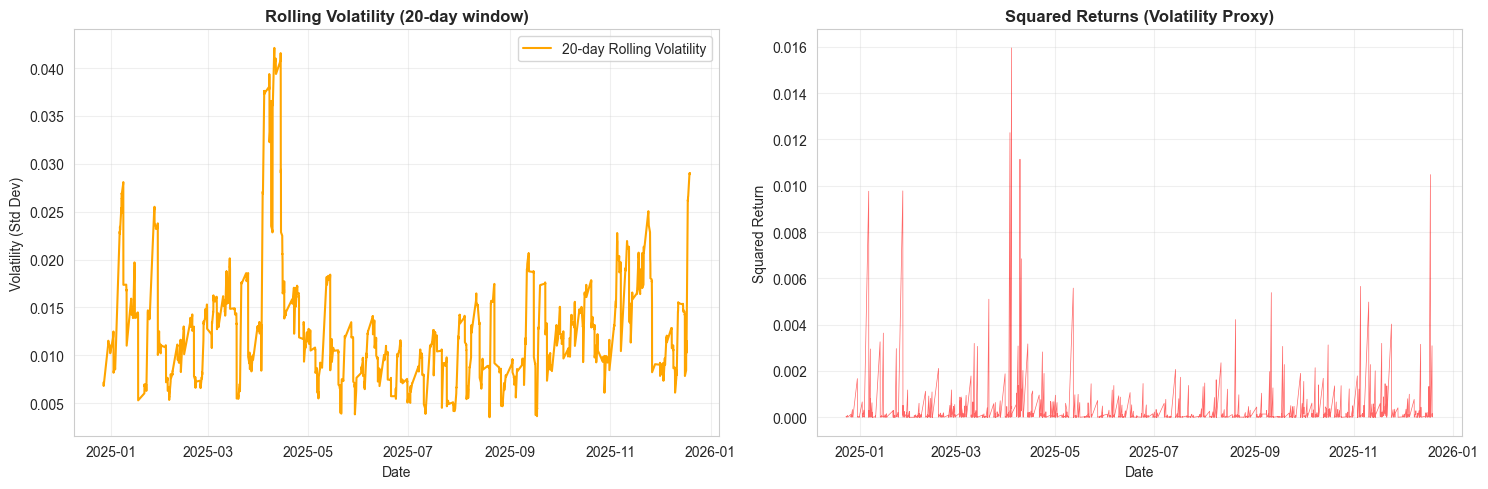

In [26]:
# Plot 2: Rolling volatility (20-day)
# Create 2 subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].plot(rolling_vol['20d'].index, rolling_vol['20d'].values, 
             label='20-day Rolling Volatility', color='orange', linewidth=1.5)
axes[0].set_title('Rolling Volatility (20-day window)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Volatility (Std Dev)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 3: Squared returns (proxy for volatility)
squared_returns = target_series ** 2
axes[1].plot(squared_returns.index, squared_returns.values, 
             alpha=0.6, color='red', linewidth=0.5)
axes[1].set_title('Squared Returns (Volatility Proxy)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Squared Return')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


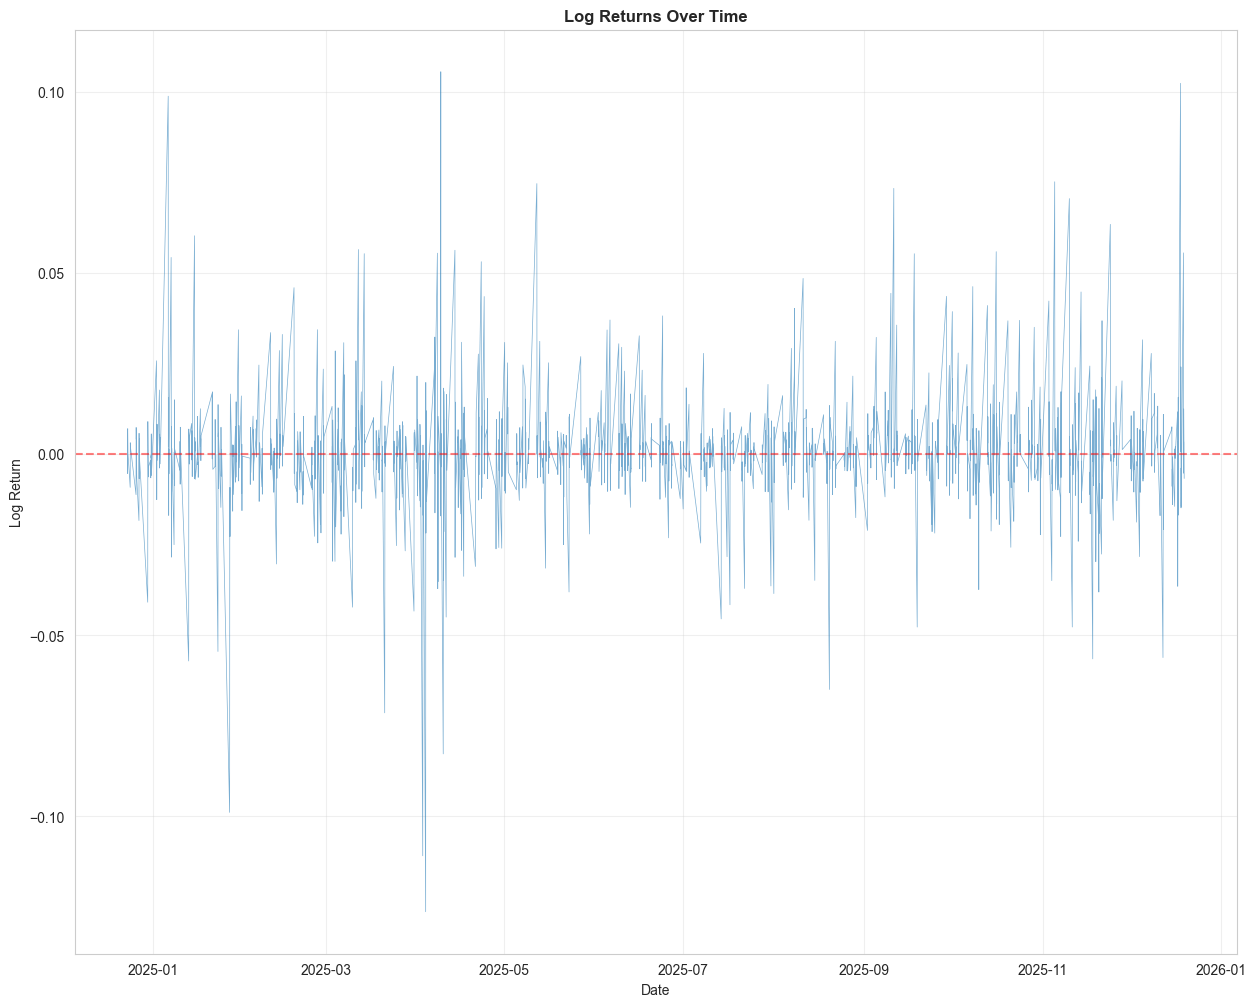

In [28]:
# 2. Visualize volatility clustering
fig, axes = plt.subplots(1, 1, figsize=(15, 12))

# Plot 1: Returns over time
axes.plot(target_series.index, target_series.values, alpha=0.6, linewidth=0.5)
axes.set_title('Log Returns Over Time', fontsize=12, fontweight='bold')
axes.set_xlabel('Date')
axes.set_ylabel('Log Return')
axes.axhline(y=0, color='red', linestyle='--', alpha=0.5)
axes.grid(True, alpha=0.3)

In [22]:
# 3. Statistical test for volatility clustering (Ljung-Box test on squared returns)
# This tests for ARCH effects (Autoregressive Conditional Heteroskedasticity)
print("=" * 70)
print("Volatility Clustering Analysis")
print("=" * 70)

# Calculate statistics
vol_mean = rolling_vol['20d'].mean()
vol_std = rolling_vol['20d'].std()
vol_min = rolling_vol['20d'].min()
vol_max = rolling_vol['20d'].max()

print(f"\nRolling Volatility Statistics (20-day window):")
print(f"  Mean: {vol_mean:.6f}")
print(f"  Std Dev: {vol_std:.6f}")
print(f"  Min: {vol_min:.6f}")
print(f"  Max: {vol_max:.6f}")
print(f"  Range Ratio (Max/Min): {vol_max/vol_min:.2f}x")

Volatility Clustering Analysis

Rolling Volatility Statistics (20-day window):
  Mean: 0.013062
  Std Dev: 0.006256
  Min: 0.003538
  Max: 0.042102
  Range Ratio (Max/Min): 11.90x


In [23]:
# Ljung-Box test on squared returns (tests for serial correlation in volatility)
# If p-value < 0.05, there is evidence of volatility clustering
lb_result = acorr_ljungbox(squared_returns.dropna(), lags=10, return_df=True)

print(f"\nLjung-Box Test on Squared Returns (tests for volatility clustering):")
print(f"  H0: No serial correlation in squared returns (no volatility clustering)")
print(f"  H1: Serial correlation exists (volatility clustering present)")
print(f"\n  Test Statistic (lag 10): {lb_result['lb_stat'].iloc[-1]:.4f}")
print(f"  p-value (lag 10): {lb_result['lb_pvalue'].iloc[-1]:.6f}")

if lb_result['lb_pvalue'].iloc[-1] < 0.05:
    print(f"\n  ✓ p-value ({lb_result['lb_pvalue'].iloc[-1]:.6f}) < 0.05")
    print(f"  ✓ VOLATILITY CLUSTERING DETECTED")
    print(f"  ✓ The variance is NOT constant over time (heteroskedasticity)")
    has_volatility_clustering = True
else:
    print(f"\n  ✗ p-value ({lb_result['lb_pvalue'].iloc[-1]:.6f}) >= 0.05")
    print(f"  ✗ No significant evidence of volatility clustering")
    has_volatility_clustering = False


Ljung-Box Test on Squared Returns (tests for volatility clustering):
  H0: No serial correlation in squared returns (no volatility clustering)
  H1: Serial correlation exists (volatility clustering present)

  Test Statistic (lag 10): 144.2582
  p-value (lag 10): 0.000000

  ✓ p-value (0.000000) < 0.05
  ✓ VOLATILITY CLUSTERING DETECTED
  ✓ The variance is NOT constant over time (heteroskedasticity)


In [24]:
print("\n" + "=" * 70)
print("Implications for LSTM Modeling:")
print("=" * 70)

if has_volatility_clustering:
    print("⚠️  Volatility clustering detected!")
    print("   - LSTMs handle this better than linear models (ARIMA)")
    print("   - However, if training set volatility differs significantly")
    print("     from test set volatility, the model may struggle")
    print("   - SOLUTION: Use StandardScaler or MinMaxScaler to normalize")
    print("     the magnitude of swings across the entire dataset")
    print("   - This ensures consistent scaling between train/test sets")
else:
    print("✓ No significant volatility clustering detected")
    print("  - Variance appears relatively constant over time")
    print("  - Still recommended to use scaling for LSTM models")

print("\n" + "=" * 70)


Implications for LSTM Modeling:
⚠️  Volatility clustering detected!
   - LSTMs handle this better than linear models (ARIMA)
   - However, if training set volatility differs significantly
     from test set volatility, the model may struggle
   - SOLUTION: Use StandardScaler or MinMaxScaler to normalize
     the magnitude of swings across the entire dataset
   - This ensures consistent scaling between train/test sets



In [25]:
# Helper functions for inverse transformation (convert predictions back to prices)

def inverse_transform_pct_return(predictions: np.ndarray, base_prices: np.ndarray) -> np.ndarray:
    """
    Convert percentage return predictions back to price predictions.
    
    Args:
        predictions: Predicted percentage returns
        base_prices: Base prices (typically previous period's close prices)
        
    Returns:
        Predicted prices
    """
    return base_prices * (1 + predictions)


def inverse_transform_log_return(predictions: np.ndarray, base_prices: np.ndarray) -> np.ndarray:
    """
    Convert log return predictions back to price predictions.
    
    Args:
        predictions: Predicted log returns
        base_prices: Base prices (typically previous period's close prices)
        
    Returns:
        Predicted prices
    """
    return base_prices * np.exp(predictions)


# Example usage (commented out - uncomment when you have predictions)
# # If you predicted percentage returns:
# predicted_prices_pct = inverse_transform_pct_return(
#     predicted_returns, 
#     df_features['close'].shift(1).values
# )
#
# # If you predicted log returns:
# predicted_prices_log = inverse_transform_log_return(
#     predicted_returns,
#     df_features['close'].shift(1).values
# )

print("Inverse transformation functions defined:")
print("  - inverse_transform_pct_return(): Convert % returns → prices")
print("  - inverse_transform_log_return(): Convert log returns → prices")


Inverse transformation functions defined:
  - inverse_transform_pct_return(): Convert % returns → prices
  - inverse_transform_log_return(): Convert log returns → prices
